In [31]:
import re
import random
import pandas as pd
import hashlib

In [32]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [33]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Terraform,58.582209,29.291105,29.791043,2
OAuth 2.0 RFC6749,165.163711,20.645464,45.433828,8
Azure Functions + PP365,203.852256,40.770451,60.557973,5
Django,303.254257,7.581356,18.246604,40
Node.js and Vite,337.443877,8.230338,18.725294,41
pfSense,489.875506,40.822959,130.569990,12
CCH Tax Forms Project,593.813780,28.276847,96.302418,21
Accounting,660.609460,38.859380,96.670010,17
Asynchronous Python,777.684220,45.746131,88.940823,17
Python + Oauth2.0,834.995391,36.304147,107.699675,23


# Histogram

sum of ages: ~44108.47


<Axes: >

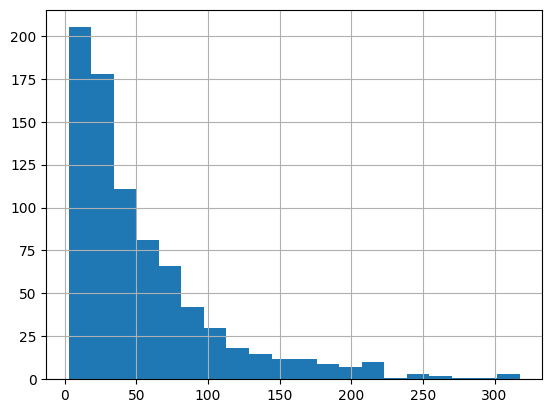

In [34]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~44108.47


<Axes: >

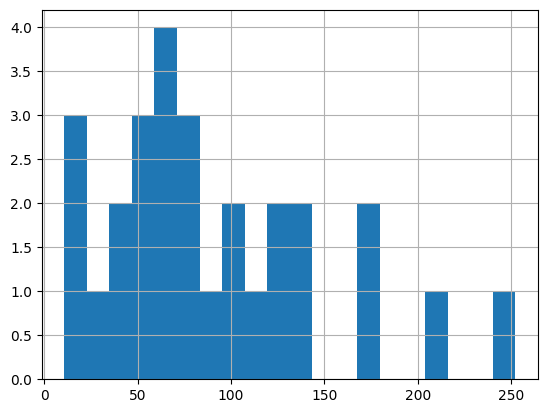

In [46]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure VM + Developer']['age'].hist(bins=20)

# Completely Random Shuffle

In [36]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [37]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [38]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [39]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [40]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [41]:
n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 807
Total card age: 44108.47


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
116,Terraform,Provisioning infrastructure across multiple cl...,6142f0024e8d0327917e9f63072277cd,29.791043,29.291105,-29.791043,58.582209,0.551693,2,0,0,-29.791043
115,Terraform,Local Values:\nDefinition: Local values allow ...,276bce2642773e24412e2540d7ed6044,28.791166,29.291105,-29.791043,58.582209,0.551693,2,1,0,-28.791166
105,Azure Functions + PP365,Function Proxies\nA feature in Azure Functions...,bf413ded3c5197d25ae6a124a6fa1574,60.557973,40.770451,-60.557973,203.852256,0.439063,5,0,0,-60.557973
106,Azure Functions + PP365,Azure Functions Extensions\nAdditional modules...,e257b743d0bf616a87dcbb83e458de17,46.013729,40.770451,-60.557973,203.852256,0.439063,5,1,0,-46.013729
107,Azure Functions + PP365,Service Bus Triggers\nTriggers that activate A...,06293e00b067780e0eafbf190b9907aa,38.461888,40.770451,-60.557973,203.852256,0.439063,5,2,0,-38.461888
110,OAuth 2.0 RFC6749,Instead of using the resource owner's credenti...,dc6c6e9573d09d468d57fad914fae9bf,45.433828,20.645464,-45.433828,165.163711,0.959231,8,0,0,-45.433828
111,OAuth 2.0 RFC6749,OAuth defines four roles:\n\n resource owner...,239bff08336e8b3c98511be7ed1e2424,37.686535,20.645464,-45.433828,165.163711,0.959231,8,1,0,-37.686535
112,OAuth 2.0 RFC6749,"The OAuth 1.0 protocol ([RFC5849]), published ...",fa67f0cf02fa18b30d2c01d93c211f6c,21.516638,20.645464,-45.433828,165.163711,0.959231,8,2,0,-21.516638
65,FSLogix,Cloud Cache uses storage providers based on th...,44842f401f56251a420f6eaae9b5b151,165.752157,75.417090,-165.752157,905.005086,0.325061,12,0,0,-165.752157
66,FSLogix,Cloud Cache uses the locally mounted container...,395fe6c9edfadeac3e8be549b66ded66,164.450201,75.417090,-165.752157,905.005086,0.325061,12,1,0,-164.450201



## Random

In [42]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [43]:
existing_cards.head(10)['age'].sum()

np.float64(638.4551584156208)

In [44]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,317.445315,64.697679,-317.445315,1552.744294,0.361997,24,0,0,-317.445315
5,VMWare,Host Failure\n\nWhen a physical ESXi host beco...,50554350b937a4d45efe1e2ea91d1c85,311.782654,100.908416,-311.782654,1412.717825,0.938187,14,0,0,-311.782654
10,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,302.533867,63.456366,-302.533867,3109.361949,0.706152,49,0,0,-302.533867
15,Vocab,"Something Rotten, Fforde\nPaella\nnoun | pah-A...",a37b3188a1d9c867d96671c96fbb61bf,286.784496,87.268775,-286.784496,3665.288558,0.400927,42,0,0,-286.784496
20,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,283.498179,73.728595,-283.498179,2654.229407,0.932575,36,0,0,-283.498179
25,Azure Compute Gallery,Compute Gallery Resource – The top-level conta...,cd4e5ebc6131cac516f3b36cdc1af298,260.715398,87.432901,-260.715398,2448.121235,0.874949,28,0,0,-260.715398
26,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,255.009920,87.432901,-260.715398,2448.121235,0.874949,28,1,0,-255.009920
35,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,252.834913,53.606261,-252.834913,3806.044525,0.616647,71,0,0,-252.834913
30,Azure VM + Developer,.env File\nA flat file storing environment var...,5c23b6d70d4d3563ba79097e051516c5,252.235456,89.832425,-252.235456,2515.307911,0.592794,28,0,0,-252.235456
40,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,247.968347,57.225884,-247.968347,1888.454165,0.838014,33,0,0,-247.968347


In [45]:
existing_cards['age'].mean()

np.float64(54.657337311314116)